# Classifying cat and dogs using Pre-trained model and Fine tuning it

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world.

Two ways to customize a pretrained model:
1. **Feature Extraction**
2. **Fine Tuning**

**Feature Extraction** : Use the representation learned by a previous network to extract meaningful features ,we add a new classifier on top of pretrained model

**Fine Tuning** Unfreeze a few of the top layers of a frozen model base and jointly train both the newly added classifier layers and the last layers of the base model

## WorkFlow

1. Examining and Visualising the data
2. Build an input pipeline
3. Compose the model
    1. Load in the pretrained base model (and pretrained weights)
    2. Stack the classification layers on top
4. Train the model
5. Evaluate the model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
! wget 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

--2024-12-24 20:06:54--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  20.5MB/s    in 4.0s    

2024-12-24 20:06:58 (16.3 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import zipfile

zip_ref= zipfile.ZipFile('./cats_and_dogs_filtered.zip','r')
zip_ref.extractall('./')
zip_ref.close()

In [4]:
train_dir = os.path.join("./cats_and_dogs_filtered/","train")
validation_dir = os.path.join("./cats_and_dogs_filtered/","validation")

In [5]:
BATCH_SIZE=32
IMG_SIZE=(224,224)

Not using ImageDataGenerator beacuse it is out dated and slow as it creates object before hand training

We will use image_dataset_from_directory which is faster than ImageDataGenerator

### Preprocessing

In [6]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [7]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(None ,224 ,224,3) where None is BATCH_SIZE (Number of images in one batch)

In [8]:
for images ,labels in train_dataset.take(1):
  print("Size of batch",images.shape)
  print("Label size",labels.shape)

Size of batch (32, 224, 224, 3)
Label size (32,)


So, In one batch 32 images are there of shape(224,224,3) and corresponding to it label of each image

### Randomly visualising some images

In [9]:
class_names=train_dataset.class_names
class_names

['cats', 'dogs']

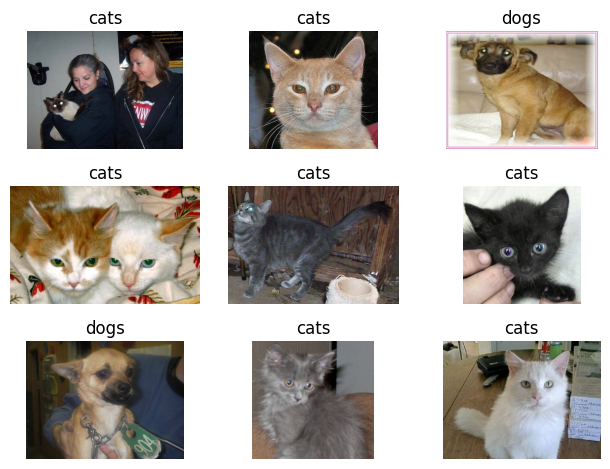

In [10]:
import random
def view_random_images():
  class_names=train_dataset.class_names
  class_labels = random.choice(class_names)
  dir_im = os.path.join( "cats_and_dogs_filtered/train/" ,class_labels)
  random_im_chosen = random.choice(os.listdir(dir_im))
  random_im_path = os.path.join(dir_im,random_im_chosen)
  img = plt.imread(random_im_path)
  # plt.figure(figsize=(3,3))
  plt.imshow(img)
  plt.title(class_labels)
  plt.axis(False)


rows=3
cols=3
for i in range(9):
  plt.subplot(3,3,i+1)
  view_random_images()
plt.tight_layout()
plt.show()

As our original dataset doesnot contain a test set , so Creating one

We are first calculating how many batches are there in validation set using tf.data.experimental.cardinality and then giving 20% to test set

In [11]:
print("Number of batches in validation set",tf.data.experimental.cardinality(validation_dataset))

Number of batches in validation set tf.Tensor(32, shape=(), dtype=int64)


In [12]:
print("Number of batches in training set",tf.data.experimental.cardinality(train_dataset))

Number of batches in training set tf.Tensor(63, shape=(), dtype=int64)


In [13]:
number_val_batches= tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(number_val_batches//5)
validation_dataset = validation_dataset.skip(number_val_batches//5)

In [14]:
print("Batches in training set" ,tf.data.experimental.cardinality(train_dataset))
print("Batches in validation set" ,tf.data.experimental.cardinality(validation_dataset))
print("Batches in test set" ,tf.data.experimental.cardinality(test_dataset))

Batches in training set tf.Tensor(63, shape=(), dtype=int64)
Batches in validation set tf.Tensor(26, shape=(), dtype=int64)
Batches in test set tf.Tensor(6, shape=(), dtype=int64)


##Data Augmentation

Its good to apply some random rotation or flip or zoom when we have a smaller dataset , this helps our model to learn more about the dataset and generalise better

using sequential API to make  a data augmentation layer

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

<Figure size 1000x1000 with 0 Axes>

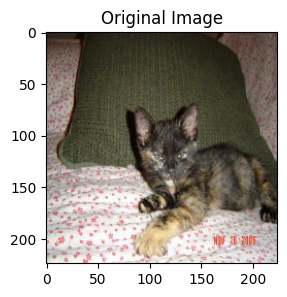

(224, 224, 3)


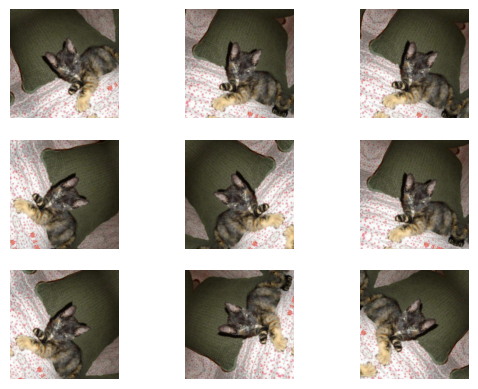

In [16]:
for image , _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  plt.figure(figsize=(3,3))
  plt.title("Original Image")
  plt.imshow(first_image/255.)
  plt.show()
  print(first_image.shape)
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image,0))
    plt.imshow(augmented_image[0]/255)
    plt.axis("off")

### Rescaling Pixel Values

tf.keras.applications.MobileNetV2 as our base model , this model expevctcs pixel values in [-1,1] ,but at this point ,pixel values are in [0,255]. To rescale them , we will use the preprocessing method included with the model

In [17]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

preprocess_input is a function that prepares the input image data before feeding it into a MobileNetV2 mode

In [18]:
# or
# rescale =tf.keras.layers.Rescaling(1./127.5 ,offset=-1)

In [19]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [20]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

### Feature Extraction

Here we will freeze the convolutional base created from the previous step and use that as a feature extractor , add a classifier on top of it and train the top-level classifier to use as a feature extractor.

Additionally we can add a classifier on top of it and train the top level classifier

### Freezing the base model

In [21]:
base_model.trainable = False

Adding a classification head on top of the base_model

Building a complete model

we are using Functional API to create a model

In [22]:
inputs = tf.keras.Input(shape=(224,224,3))
x=data_augmentation(inputs)
x=preprocess_input(x)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dropout(0.2)(x)
outputs=tf.keras.layers.Dense(1,activation='sigmoid')(x)


model = tf.keras.Model(inputs,outputs)

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

we did Pooling layer global because when our image comes out of base model ,size id (32 ,7,7,1280) ,we are using pooling layer to bring it to v(32 ,1280)

In [24]:
len(model.trainable_variables )

2

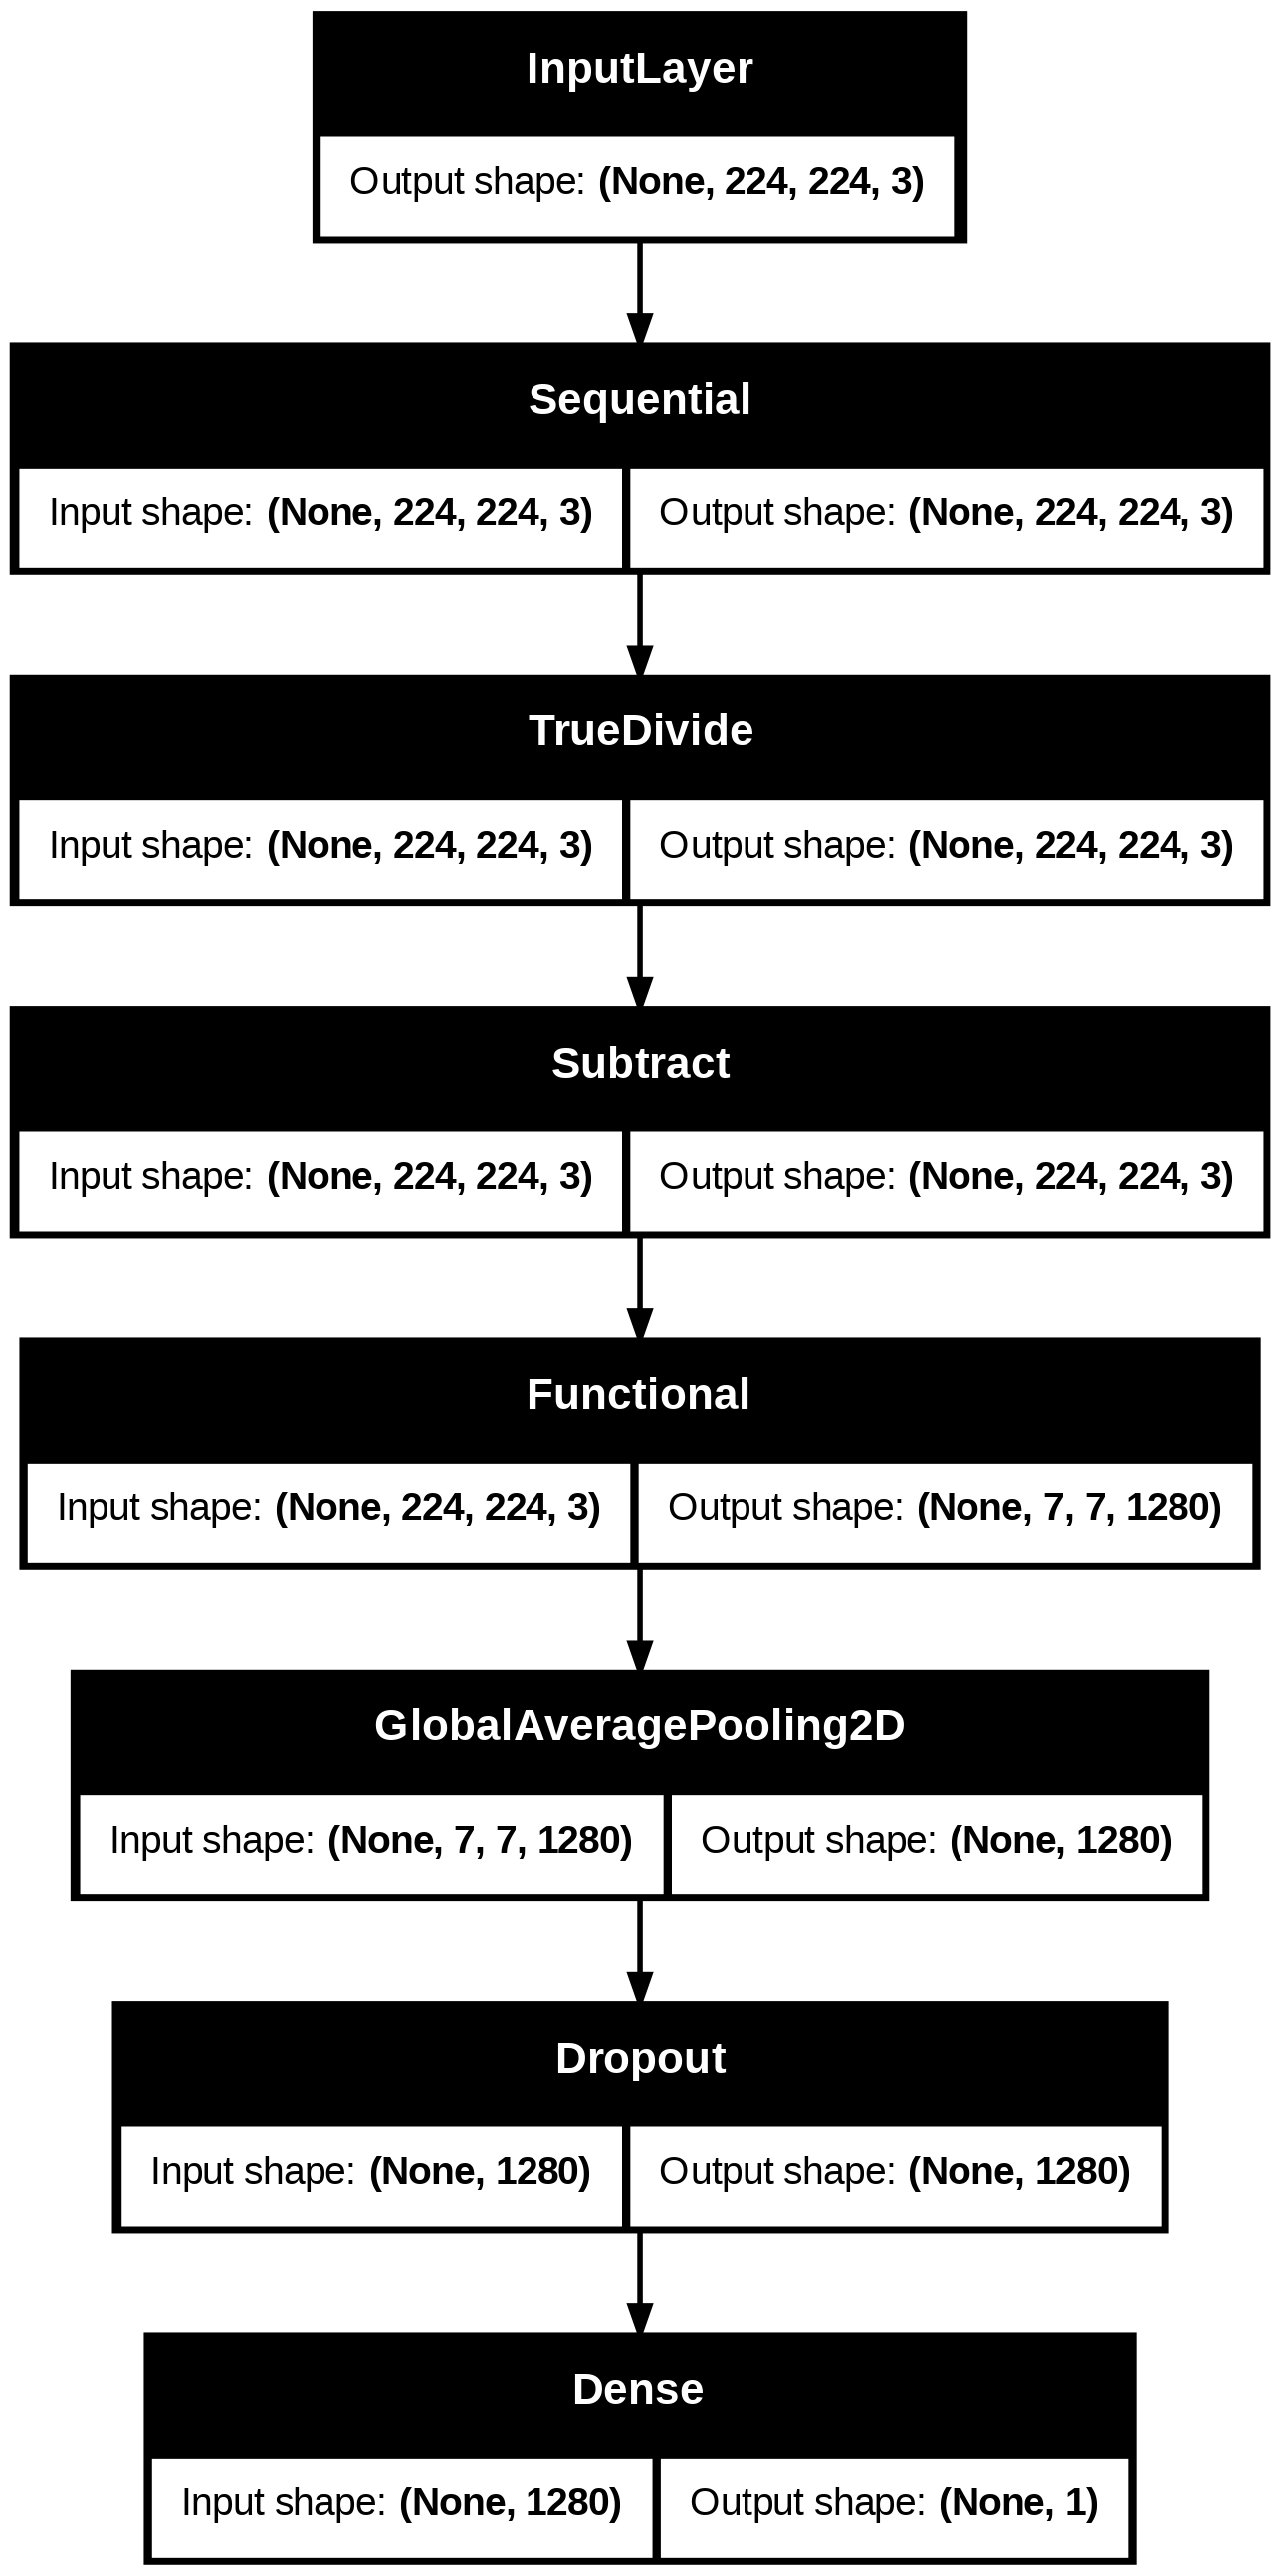

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compiling the model

In [26]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

### Training the Model

In [27]:
initial_epochs=10

history0=model.fit(train_dataset,
                  epochs=initial_epochs,
                  validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - accuracy: 0.6990 - loss: 0.5796 - val_accuracy: 0.9047 - val_loss: 0.3693
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.8193 - loss: 0.4310 - val_accuracy: 0.9493 - val_loss: 0.2699
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.8698 - loss: 0.3362 - val_accuracy: 0.9678 - val_loss: 0.2124
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.9095 - loss: 0.2759 - val_accuracy: 0.9715 - val_loss: 0.1775
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9204 - loss: 0.2359 - val_accuracy: 0.9765 - val_loss: 0.1491
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9164 - loss: 0.2310 - val_accuracy: 0.9851 - val_loss: 0.1246
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9299 - loss: 0.2018 - val_accuracy: 0.9851 - val_loss: 0.1138
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9442 - loss: 0.1748 - val_accuracy: 0.

In [37]:
model.evaluate(validation_dataset)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9914 - loss: 0.0877


[0.0914478600025177, 0.9851484894752502]

In [35]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy=history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


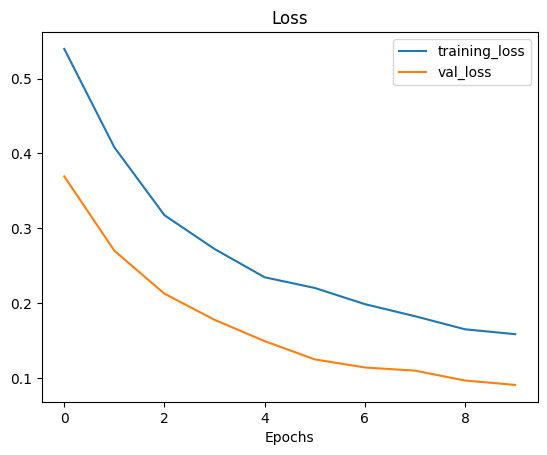

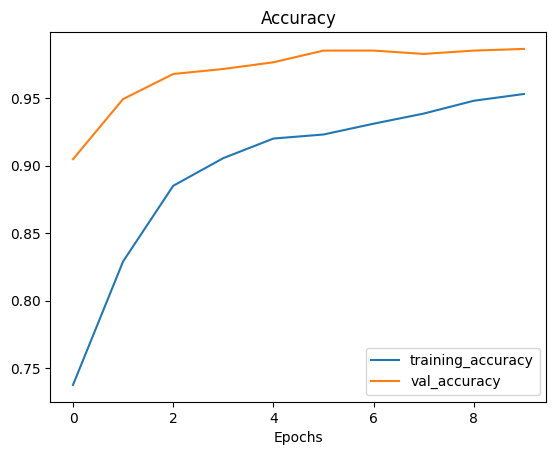

In [36]:
plot_loss_curves(history0)

### Fine Tuning

In the feature extraction experiment, we were only training a few layers on top of an MobileNetV2 base model. The weights of the pre trained network were not getting updated during training

One way to increase performance even further is to train the weights of the top layers of the pre trained model alongside the training of the classifier we have added

We should ffine tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks ,the higher up a layer it is , the more specialized it is.

####Un-Freeze the top layers of the model

We need to unfreeze the base_model and set the bottom layers to be un-trainable. Then we will recompile the model and resume training.

In [38]:
base_model.trainable= True # First time doing this , excited

In [41]:
base_model.layers

[<InputLayer name=input_layer_1, built=True>,
 <Conv2D name=Conv1, built=True>,
 <BatchNormalization name=bn_Conv1, built=True>,
 <ReLU name=Conv1_relu, built=True>,
 <DepthwiseConv2D name=expanded_conv_depthwise, built=True>,
 <BatchNormalization name=expanded_conv_depthwise_BN, built=True>,
 <ReLU name=expanded_conv_depthwise_relu, built=True>,
 <Conv2D name=expanded_conv_project, built=True>,
 <BatchNormalization name=expanded_conv_project_BN, built=True>,
 <Conv2D name=block_1_expand, built=True>,
 <BatchNormalization name=block_1_expand_BN, built=True>,
 <ReLU name=block_1_expand_relu, built=True>,
 <ZeroPadding2D name=block_1_pad, built=True>,
 <DepthwiseConv2D name=block_1_depthwise, built=True>,
 <BatchNormalization name=block_1_depthwise_BN, built=True>,
 <ReLU name=block_1_depthwise_relu, built=True>,
 <Conv2D name=block_1_project, built=True>,
 <BatchNormalization name=block_1_project_BN, built=True>,
 <Conv2D name=block_2_expand, built=True>,
 <BatchNormalization name=block

In [43]:
# Lets see how many layers are in the base model
print("Number of layers in the base model: ",len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


So we are essentially training the base model from 100 to 154 and then out model that we made on top of the base Resnet model

In [44]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [45]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [46]:
len(model.trainable_variables)

56

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

### First time me running a fine tuned model

In [48]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history0.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.8237 - loss: 0.3623 - val_accuracy: 0.9889 - val_loss: 0.0500
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 0.9143 - loss: 0.2194 - val_accuracy: 0.9851 - val_loss: 0.0421
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.9319 - loss: 0.1767 - val_accuracy: 0.9864 - val_loss: 0.0331
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.9496 - loss: 0.1339 - val_accuracy: 0.9851 - val_loss: 0.0304
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9582 - loss: 0.1115 - val_accuracy: 0.9889 - val_loss: 0.0267
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.9670 - loss: 0.0993 - val_accuracy: 0.9901 - val_loss: 0.0259
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9691 - loss: 0.0836 - val_accuracy: 0.9889 - val_loss: 0.0276
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.9681 - loss: 0.0882 - val_

In [49]:


acc=history0.history["accuracy"]+history_fine.history["accuracy"]
val_acc =history0.history["val_accuracy"]+history_fine.history["val_accuracy"]

loss=history0.history["loss"]+history_fine.history["loss"]
val_loss=history0.history["val_loss"]+history_fine.history["val_loss"]
_

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1], dtype=int32)>

In [51]:
model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9927 - loss: 0.0263


[0.023806389421224594, 0.9913366436958313]

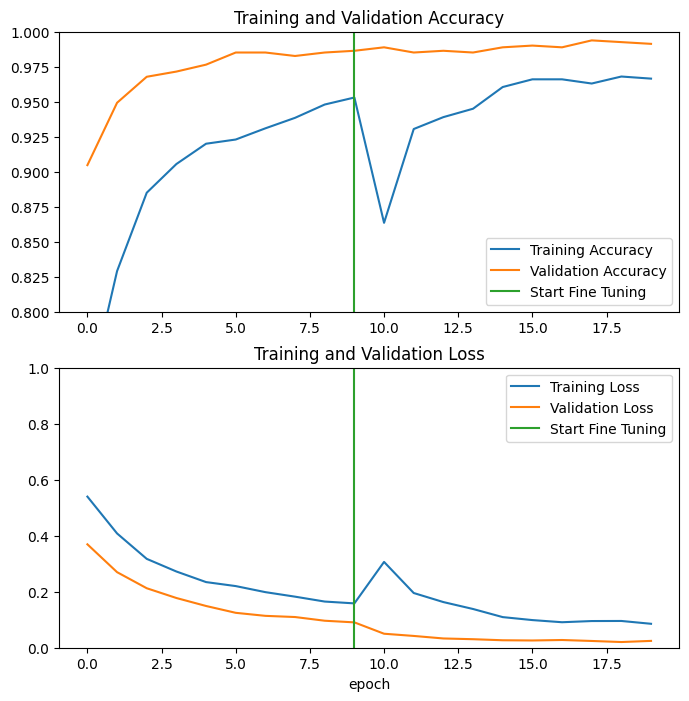

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

In [55]:
loss,accuracy=model.evaluate(test_dataset)
print("Accuracy",accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0095
Accuracy 1.0


Predictions:
 [1 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 1]
Labels:
 [1 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 1]


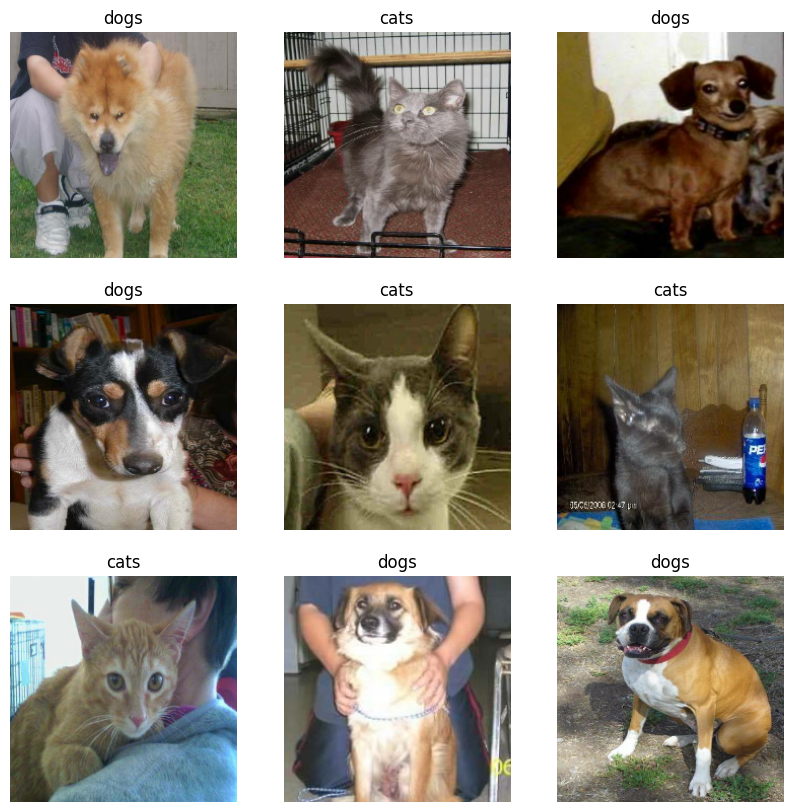

In [61]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary


1. Feature Extraction - When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same doamin. This is done by using a pretrained model and adding a FCNN on top of it. The pretrained model is kept frozen and only the weights of the classifier get updated during training. In this case ,the conv base extrcated all the features associated wuth each image and we just trained a classifier that determines the image class given that the set of extracted features.

2. Fine tuning a pre trained model: To further improve performance, one might want to train some of the top layers of the pre trained models to the new dataset via fine tuning. In this case , we tuned our weights such that our model learned high level features that is more specific to our datset, For this since we are training more layers , so we need more data as compared to that needed for just doing feature extraction